# Devoir n° 2



Définition d'une classe abstraite de base pour toutes
couches que vous développerez.

In [2]:
import numpy as np
from matplotlib import pyplot as plt


class Couche:
    def __call__(self, *args):
        return self.forward(*args)

    def forward(self, *args):
        pass

    def backward(self, grad=None):
        pass

    def update(self, lr):
        pass

    def zero_grad(self):
        pass

Tout au long de ce devoir, veillez vous assurez que les vecteurs aient la taille `(1, N)` ou `(N, 1)` plutôt que `(N,)`.</br>
Aussi lorsque vous faites une opération de réduction (somme, moyenne, etc...) sur un tenseur de taille `(M,N)`,
</br>assurez vous que la taille du résultat est `(1, N)` ou `(M, 1)` selon la dimension
choisie et non `(N,)` ou `(M,)`.

Exécutez la cellule ci-dessous pour en voir un exemple.


In [3]:
a = np.arange(60).reshape(4,5,3)
b = a.sum(axis=0, keepdims=True)
c = a.sum(axis=0)

print(b.shape, c.shape)

(1, 5, 3) (5, 3)


## Réseau de neurones à une couche

Veillez remplir les `...` par du code en vous inspirant du notebook du cours.




In [4]:
class Lineaire(Couche):
    def __init__(self,  dim_entree: int, dim_sortie:int):
        # compléter cette partie
        self.b = np.zeros(dim_sortie)
        self.W = np.random.randn(dim_entree, dim_sortie) * np.sqrt(2 / dim_entree)
        self.W_grad = np.zeros_like(self.W)
        self.b_grad = np.zeros_like(self.b)

    def forward(self, entree):
        self.entree = entree
        # compléter cette partie
        sortie = sortie = np.dot(entree, self.W) + self.b
        return sortie

    def backward(self, grad):
        # compléter cette partie
        self.entree_grad = np.dot(grad, self.W.T)
        self.W_grad += np.dot(self.entree.T, grad)
        self.b_grad += np.sum(grad, axis=0)
        return self.entree_grad

    def update(self, lr):
        # compléter cette partie
        self.W = self.W - lr * self.W_grad
        self.b = self.b - lr * self.b_grad

    def zero_grad(self):
        self.W_grad.fill(0)
        self.b_grad.fill(0)

In [5]:
# Exécuter cette cellule ne doit produire aucune erreur
entree_ = np.array([1, -1])[None]
sortie_ = np.array([10])[None]
# Définir un modèle d'une couche liant les entrée et sortie définies
model = Lineaire(2, 1)
sortie_predite = model(entree_)
assert sortie_predite.shape == sortie_.shape
print(sortie_predite)

[[-0.6404824]]


### Log Cosh Loss

La fonction cosinus hyperbolique  se définit par:
$x\in \mathbb{R}^N$

$$LogCosh(x) =  log(cosh(x))$$
$$LogCosh(x) =  log(\frac{e^x + e^{-x}}{2})$$

Avec $x = y_{prédit} - y_{réel}$

Dérivation:

$$
(log(cosh(x)))' = \frac{cosh'(x)}{cosh(x)}  
                = \frac{sinh(x)}{cosh(x)} 
                = tanh(x)  
%                    = \frac{e^x(1 - e^{-2x})^2}{2(1 + e^{-2x})}  
$$

In [6]:
class LogCoshLoss(Couche):
    def forward(self, sortie_reelle, sortie_predite):
        self.sortie_reelle = sortie_reelle
        self.sortie_predite = sortie_predite
        x = sortie_predite - sortie_reelle
        perte = np.log(np.cosh(x))
        return perte

    def backward(self, grad=None):
        x = self.sortie_predite - self.sortie_reelle
        grad_loss = np.tanh(x)
        if grad is not None:
            grad_loss *= grad
        return grad_loss


In [7]:
# Compléter la fonction ci-dessous pour faire un entraînement
# sur le nombre d'époques spécifiées, suivant le rythme lr et
# l'ensemble des paramètres spécifiés
def fit(model, entrees, sorties, loss_func, epoques, lr):
    for i in range(epoques):
        sortie_predites = model(entrees)
        lossvalue = loss_func(sorties, sortie_predites)
        print(f'Epoque #{i}  loss: {lossvalue} ')
        sortie_predites_grad = loss_func.backward()
        model.backward(sortie_predites_grad)
        model.update(lr)
        model.zero_grad()
    #assert (np.abs(sortie_predites - sorties) < 1e-5).all()
    print(f'prediction:{sortie_predites[0,0]}\t cible:{sorties[0,0]}')

In [8]:
# Exécuter cette cellule ne doit produire aucune erreur


epoques = 10
lr = 0.2

entree_ = np.array([1, -1, 0.5, 4])[None]
sortie_ = np.array([10, 3])[None]
loss = LogCoshLoss()
# Définir un modèle d'une couche liant les entrée et sortie définies
model = Lineaire(4, 2)

fit(model, entree_, sortie_, loss, epoques, lr)

Epoque #0  loss: [[11.50951188  4.24502646]] 
Epoque #1  loss: [[7.65951193 0.50276853]] 
Epoque #2  loss: [[3.80963505 1.30321271]] 
Epoque #3  loss: [[0.19992627 1.06576965]] 
Epoque #4  loss: [[0.90699515 1.21611506]] 
Epoque #5  loss: [[1.29190569 1.12480052]] 
Epoque #6  loss: [[1.07363766 1.18212604]] 
Epoque #7  loss: [[1.21174186 1.14674544]] 
Epoque #8  loss: [[1.12766136 1.16883905]] 
Epoque #9  loss: [[1.18041284 1.15513607]] 
prediction:8.150906611410969	 cible:10


## L'activation softplus 

Il existe plusieurs fonctions d'activation parmi lesquelles
compte la fonction softplus
qui est dérivable en zéro contrairement à la fonction RELU définie par:


$softplus(x) = log(1+e^x)$

Si $ \begin{align}
    x &= \begin{bmatrix}
           x_{1} \\
           x_{2} \\
           \vdots \\
           x_{n}
         \end{bmatrix}
  \end{align}$, alors
$ \begin{align}
    f(x) &= \begin{bmatrix}
           f(x_{1}) \\
           f(x_{2}) \\
           \vdots \\
           f(x_{n})
         \end{bmatrix}
  \end{align}
\text{ pour } f \text{ une fonction d'activation}
$

Dérivation :

$$softplus'(x) = \sigma(x) = \frac{1}{1+e^{-x}}$$


#### Tracer les courbes des fonctions softplus et RELU sur l'intervalle [-20,20] afin de voir les similarités et différences:

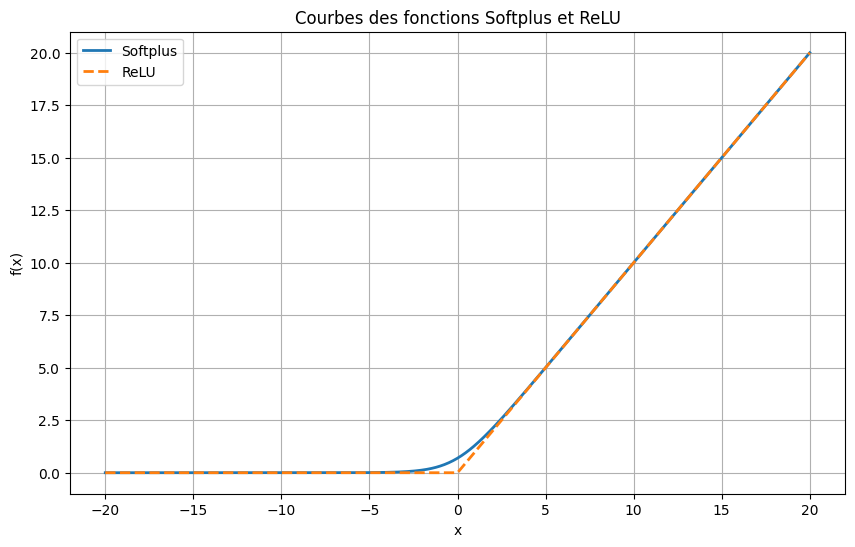

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Définition des fonctions d'activation
def softplus(x):
    return np.log(1 + np.exp(x))

def relu(x):
    return np.maximum(0, x)

# Définition de l'intervalle
x_values = np.linspace(-20, 20, 1000)

# Calcul des valeurs des fonctions pour chaque point de l'intervalle
softplus_values = softplus(x_values)
relu_values = relu(x_values)

# Tracé des courbes
plt.figure(figsize=(10, 6))

plt.plot(x_values, softplus_values, label='Softplus', linewidth=2)
plt.plot(x_values, relu_values, label='ReLU', linewidth=2, linestyle='--')

# Ajout de titres et de légendes
plt.title('Courbes des fonctions Softplus et ReLU')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

# Affichage du graphe
plt.grid(True)
plt.show()


In [10]:
# Compléter le code ci-dessous pour l'activation softplus.
class Softplus(Couche):
    def forward(self, entree_):
        self.entree_ = entree_
        # compléter cette partie
        self.sortie_ = np.log(1 + np.exp(entree_))
        return self.sortie_
    
    def backward(self, sortie_grad):
        # compléter cette partie
        
        # gradient softplus
        self.grad = 1 / (1 + np.exp(-self.entree_))
        # gradient relativement au loss
        self.entree_grad = self.grad * sortie_grad 
        return self.entree_grad

#### Test de l'activation softplus

Aucune erreur ne doit se produire en exécutant la cellule ci-dessous.

In [11]:
softplus = Softplus()
entree_ = np.expand_dims(np.array([1, 0.5, 0, -0.5, -1]), 0)
sortie_ = softplus(entree_) 
assert sortie_.shape == entree_.shape, 'Erreur, dimensions non conservée'
assert (sortie_ != entree_).all(), 'Erreur, entrée égale à la sortie'
assert (sortie_ > 0).all(), 'Erreur, sortie ayant des valeurs ≤ 0'
softplus.backward(entree_)
print(f'Gradient calculée:\n {softplus.grad.T}', '\n')
h=1e-6
approx_grad = (softplus(entree_+h) - softplus(entree_-h))/(2*h)
print(f'Gradient approximatif:\n {approx_grad.T}', '\n')
print(f'Différence entre Gradients calculé et approximatif:\n {(softplus.grad - approx_grad).T}')
assert (np.abs(softplus.grad - approx_grad) < h).all()

Gradient calculée:
 [[0.73105858]
 [0.62245933]
 [0.5       ]
 [0.37754067]
 [0.26894142]] 

Gradient approximatif:
 [[0.73105858]
 [0.62245933]
 [0.5       ]
 [0.37754067]
 [0.26894142]] 

Différence entre Gradients calculé et approximatif:
 [[ 6.75225431e-11]
 [ 1.19816379e-11]
 [-6.98889835e-11]
 [ 1.47738488e-11]
 [ 4.24996704e-11]]


# Perceptron Multicouche

Le but de cette partie est de mettre en place un réseau Perceptron multicouche de profondeur arbitraire !

In [12]:
from typing import List

class MLP(Couche):
    def __init__(self, couches: List[Couche]):
        self.couches = couches

    def forward(self, entree):
        sortie = entree
        for couche in self.couches:
            sortie = couche.forward(sortie)
        return sortie

    def backward(self, loss_grad):
        sortie_grad = loss_grad
        for couche in reversed(self.couches):
            sortie_grad = couche.backward(sortie_grad)

    def update(self, lr):
        # compléter cette partie
        for couche in self.couches:
            couche.update(lr)

    def zero_grad(self):
        # compléter cette partie
        for couche in self.couches:
            couche.zero_grad()

In [15]:
# Exécuter cette cellule ne doit produire aucune erreur
epoques = 20
lr = 0.2
loss = LogCoshLoss()
entree_ = np.array([1, -1, 2.])[None]
sortie_ = np.array([10])[None]
# Écrire un modèle MLP dont les nombres de neurones
# par couche sont: 4 --> 3 --> 2 --> 1 et la dernière couche est sans activation.
# 
couche1 = Lineaire(3,3)
couche2 = Lineaire(3, 2)
couche3 = Lineaire(2, 1)
model = MLP([couche1, Softplus(), couche2, Softplus(), couche3])

fit(model, entree_, sortie_, loss, epoques, lr)

Epoque #0  loss: [[8.68549685]] 
Epoque #1  loss: [[8.26698377]] 
Epoque #2  loss: [[7.80331486]] 
Epoque #3  loss: [[7.27234894]] 
Epoque #4  loss: [[6.63838922]] 
Epoque #5  loss: [[5.83698827]] 
Epoque #6  loss: [[4.7307236]] 
Epoque #7  loss: [[2.93443804]] 
Epoque #8  loss: [[0.1511457]] 
Epoque #9  loss: [[2.70214526]] 
Epoque #10  loss: [[0.00904663]] 
Epoque #11  loss: [[0.33334749]] 
Epoque #12  loss: [[4.18229539]] 
Epoque #13  loss: [[3.59203804]] 
Epoque #14  loss: [[2.06541817]] 
Epoque #15  loss: [[0.20282603]] 
Epoque #16  loss: [[0.45407035]] 
Epoque #17  loss: [[0.79472894]] 
Epoque #18  loss: [[0.36317284]] 
Epoque #19  loss: [[0.70299691]] 
prediction:8.671687100554255	 cible:10


## Application au dataset MNIST

In [17]:
from torchvision.datasets import MNIST
from sklearn.model_selection import StratifiedShuffleSplit

mnist = MNIST('./', download=True)

(x, y) = (mnist.train_data.numpy(), mnist.train_labels.numpy())
sss = StratifiedShuffleSplit(n_splits=3, test_size=1./3., random_state=10)
idxs = sss.split(x, y)
i=0
for train_idxs, test_idxs in idxs:
    (x_train, y_train) = (x[train_idxs], y[train_idxs])
    (x_test, y_test) =   (x[test_idxs], y[test_idxs])
    break

x_train, x_test = x_train / 255.0, x_test / 255.0
 

ModuleNotFoundError: No module named 'torchvision'

In [181]:
print("x shape is", x_train.shape)
print("y shape is", y_train.shape)

In [182]:
print("x shape is", x_test.shape)
print("y shape is", y_test.shape)

In [183]:
import matplotlib.pyplot as plt

def plot_image(array):
    plt.imshow(array, cmap='gray_r');

plot_image(np.hstack(x_train[1:10]))
print(y_train[1:10])

In [127]:
from time import time
# Compléter cette fonction pour l'entraînement par lot de données
def fit_batch(model, x, y, bs, loss_func, epoques, lr):
    """
    bs: taille du lot ou batch de données
    """
    entrees = x.copy()
    sorties = y.copy()
    all_losses = []
    N = entrees.shape[0]
    t = time()
    for i in range(epoques):
        losses = []
        # Re-agencement aléatoire des données
        shuffle = np.random.permutation(N)
        entrees = entrees[shuffle]
        sorties = sorties[shuffle]
        for k in range(0, N, bs):
            sorties_predites = ...
            lossvalue = ...
            losses.append(lossvalue)
            sortie_predite_grad = ...
            ...
            ...
        all_losses += losses
        if i%10 == 0:
            print(f'Epoque #{i}\tloss: {round(np.mean(losses), 3)}\ttime: {round(time() - t, 3)} ')
            t = time()
            
    return all_losses

## Modèles Regressifs

In [158]:
# Exécuter cette cellule ne doit produire aucune erreur


# Convertis les images en vecteurs
entrees = x_train.reshape((-1, 28*28))
sorties = y_train.reshape((-1,1))
# Écrire un modèle MLP dont les nombres de neurones
# par couche sont: 784 --> 50 --> 1 et la dernière couche est sans activation.
# 
model = ...
bs=100
loss_func = LogCoshLoss()
epoques=100
lr=0.01
losses = fit_batch(model, entrees, sorties, bs, loss_func, epoques, lr)

In [ ]:
def plot_loss(losses):
    # Écrire le code pour afficher l'évolution du loss
    # en fonction des itérations(batch)
    pass

### Evaluation du modèle régressif sur les données de test

In [ ]:
# Compléter le code pour évaluer le modèle
def mesure_performance(model, xt, yt):
    # arrondir la prédiction à l'entier le plus proche.
    y_predit = ...
    return ...


xt = x_test.reshape((-1, 28*28))
yt = y_test.reshape((-1,1))
mesure_performance(model, xt, yt)

### En profondeur

Écrire un modèle MLP `model_profond` dont les nombres de neurones
par couche sont: `784 --> 50 --> 10 --> 1` et la dernière couche est sans activation.

Entraîner ce modèle,l'Évaluer et le comparer au modèle précédent. Quel est le meilleur? Justifier votre réponse


In [ ]:
# Code

In [238]:
torch.cosh(torch.tensor(-1)).log()

tensor(0.4338)

## Passons à PyTorch
Tous les entraînements qui suivront se feront sur 100 époques avec la même architecture:

784 --> 50 --> 10 --> 1 ou 10

Pour la dernière couche, 1 est utilisé pour la régression et 10 pour la crossentropy et le loss de ciszar définie plus bas.

### 1. Entraîner de nouveau le modèle précédent (même architecture) avec PyTorch et la fonction de loss MSE.</br>Réaliser les mêmes évaluations. Comparer les résultats au précédent.

In [ ]:
import torch
from torch import nn

...
# sauvegarder les valeurs du loss à chaque époque dans la variable mseloss

### 2. Entraîner le même réseau avec la fonction de loss nommée `crossentropy` en ajoutant le softmax à la suite de la dernière couche.</br> Réaliser les mêmes évaluations et enregistrer les valeurs du loss. Comparer le résultat au précédent. Quel est le meilleur? Que peut-on dire de l'impact du choix de la fonction de loss dans l'entraînement d'un modèle

In [ ]:
....
# sauvegarder les valeurs du loss à chaque époque dans la variable celoss

### 3. Une autre fonction de loss: Divergence de Csízar

$$S(p,q) = \sum_{i=0}^{9} [\frac{(p_i+q_i)(p_i-q_i)^2}{p_iq_i}] \ln [\frac{p_i+q_i}{2\sqrt{p_iq_i}}]$$

Cette formule est le loss appliqué entre une prédiction ($q = y'$) et son résultat attendue ($p = y$) car nous
avons 10 catégories de chiffres dans la base MNIST.

Dans notre cas, $p = y$ et $q = y'$ où y est la prédiction et y est le résultat attendu.


In [ ]:
def divergence_ciszar(ypred, ytrue):
  # Implémenter la formule en ajoutant un epsilon = 1e-10 à chaque 
  # dénominateur pour éviter une division par zéro et supposant que
  # ypred et ytrue sont des PyTorch tensors
  ....
  
  res = ...
  return res

Pour vous aider, vous pouvez tester la fonction sur les données suivantes.
`divergence_ciszar(y1, y1_prime)` doit donner une valeur scalaire de même son application à y_batch et y_prime_batch.

In [ ]:
y1 = torch.tensor([0.004, 0.031, 0.109, 0.219, 0.274, 0.219, 0.109, 0.031, 0.004])
y1_prime = torch.tensor([0.005, 0.030, 0.104, 0.220, 0.282, 0.220, 0.104, 0.030, 0.005])

y2 = torch.tensor([0.017, 0.090, 0.209, 0.279, 0.232, 0.124, 0.041, 0.008, 0.001])
y2_prime = torch.tensor([0.020, 0.082, 0.198, 0.285, 0.244, 0.124, 0.037, 0.007, 0.0007])

y_batch = torch.stack([y1, y2])
y_prime_batch = torch.stack([y2, y2_prime])

In [4]:
y1.shape, y_batch.shape

(torch.Size([9]), torch.Size([2, 9]))

Compléter le code du loss de Ciszar et l'utiliser en replacement de la crossentropy utilisée précédemment pour entraîner le modèle

In [ ]:
class CiszarLoss(nn.Module):
    def __init__(self):
        super(CiszarLoss, self).__init__()

    def forward(self, outputs, targets):
        # Calculer le loss en utilisant la fonction divergence_ciszar
        loss = ....
        return loss

In [ ]:
...
# sauvegarder les valeurs du loss à chaque époque dans la variable ciszarloss

Afficher sur un même graphe, l'évolution des trois losses: mseloss, celoss and ciszarloss.
Commenter les vitesses de convergence des uns par rapport aux autres.

< commentaire >

**Félicitations !** </br>
Vous avez dorénavant une bonne compréhension de la lourde artillerie embarquée dans les frameworks de Deep Learning !